# Quick introduction


erddapy can be installed with conda


```shell
conda install --channel conda-forge erddapy
```

 or pip

```shell
pip install erddapy
```

First we need to instantiate the ERDDAP URL constructor for a server.
In this example we will use [https://gliders.ioos.us/erddap](https://gliders.ioos.us/erddap/index.html).

In [1]:
from erddapy import ERDDAP


e = ERDDAP(
    server="https://gliders.ioos.us/erddap",
    protocol="tabledap",
    response="csv",
)

Now we can populate the object a dataset id, variables of interest, and 
its constraints. We can download the csvp response with the `.to_pandas` method.

In [2]:
e.dataset_id = "whoi_406-20160902T1700"

e.variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]

e.constraints = {
    "time>=": "2016-07-10T00:00:00Z",
    "time<=": "2017-02-10T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}


df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
).dropna()

df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-03 20:15:46+00:00,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46+00:00,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46+00:00,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46+00:00,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46+00:00,8.43,40.990881,-71.12439,32.224503,20.5691


Text(0, 0.5, 'Depth (m)')

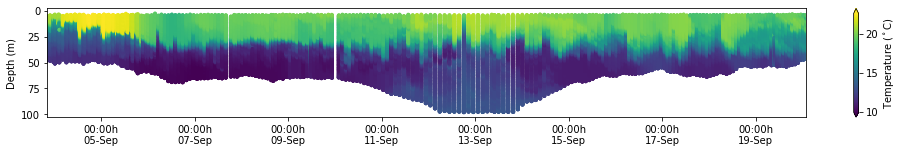

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(
    df.index,
    df["depth (m)"],
    s=15,
    c=df["temperature (Celsius)"],
    marker="o",
    edgecolor="none"
)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation="vertical", extend="both")
cbar.ax.set_ylabel("Temperature ($^\circ$C)")
ax.set_ylabel("Depth (m)");

# Longer introduction

Let's explore the methods and attributes available in the ERDDAP object?

In [4]:
from erddapy import ERDDAP


e = ERDDAP(server="https://gliders.ioos.us/erddap")

[method for method in dir(e) if not method.startswith("_")]

['auth',
 'constraints',
 'dataset_id',
 'get_categorize_url',
 'get_download_url',
 'get_info_url',
 'get_search_url',
 'get_var_by_attr',
 'protocol',
 'requests_kwargs',
 'response',
 'server',
 'to_iris',
 'to_ncCF',
 'to_pandas',
 'to_xarray',
 'variables']

All the *get_<methods>* will return a valid ERDDAP URL for the requested response and options. For example, a search for all datasets available.

In [5]:
url = e.get_search_url(search_for="all", response="csv")

print(url)

https://gliders.ioos.us/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=(ANY)&maxLon=(ANY)&minLat=(ANY)&maxLat=(ANY)&minTime=(ANY)&maxTime=(ANY)&searchFor=all


There are many responses available, see the docs for [griddap](https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html) and
[tabledap](https://coastwatch.pfeg.noaa.gov/erddap/tabledap/documentation.html) respectively.
The most useful ones for Pythonistas are the .csv and .nc that can be read with pandas and netCDF4-python respectively.

Let's load the csv response directly with pandas.

In [6]:
import pandas as pd


df = pd.read_csv(url)
print(
    f'We have {len(set(df["tabledap"].dropna()))} '
    f'tabledap, {len(set(df["griddap"].dropna()))} '
    f'griddap, and {len(set(df["wms"].dropna()))} wms endpoints.'
)

We have 785 tabledap, 0 griddap, and 0 wms endpoints.


We can refine our search by providing some constraints.

Let's narrow the search area, time span, and look for **sea_water_temperature** .

In [7]:
from erddapy.doc_helpers import show_iframe


kw = {
    "standard_name": "sea_water_temperature",
    "min_lon": -72.0,
    "max_lon": -69.0,
    "min_lat": 38.0,
    "max_lat": 41.0,
    "min_time": "2016-07-10T00:00:00Z",
    "max_time": "2017-02-10T00:00:00Z",
    "cdm_data_type": "trajectoryprofile"
}


search_url = e.get_search_url(response="html", **kw)
show_iframe(search_url)

Note that the search form was populated with the constraints we provided.

Changing the response from html to csv we load it in a data frame.

In [8]:
search_url = e.get_search_url(response="csv", **kw)
search = pd.read_csv(search_url)
gliders = search["Dataset ID"].values

gliders_list = "\n".join(gliders)
print(f"Found {len(gliders)} Glider Datasets:\n{gliders_list}")

Found 16 Glider Datasets:
blue-20160818T1448
cp_335-20170116T1459
cp_336-20161011T0027
cp_336-20170116T1254
cp_340-20160809T0230
cp_374-20160529T0035
cp_374-20161011T0106
cp_376-20160527T2050
cp_379-20170116T1246
cp_380-20161011T2046
cp_387-20160404T1858
cp_388-20160809T1409
cp_389-20161011T2040
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


Now that we know the Dataset ID we can explore their metadata with the *get_info_url* method.

In [9]:
glider = gliders[-1]

info_url = e.get_info_url(dataset_id=glider, response="html")

show_iframe(src=info_url)

We can manipulate the metadata and find the variables that have the *cdm_profile_variables* attribute using the csv response.

In [10]:
info_url = e.get_info_url(dataset_id=glider, response='csv')

info = pd.read_csv(info_url)
info.head()

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,This deployment supported by NOAA through the ...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"time_uv,lat_uv,lon_uv,u,v,profile_id,time,lati..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory,wmo_id"
4,attribute,NC_GLOBAL,comment,String,Glider operatored by Woods Hole Oceanographic ...


In [11]:
"".join(info.loc[info["Attribute Name"] == "cdm_profile_variables", "Value"])

'time_uv,lat_uv,lon_uv,u,v,profile_id,time,latitude,longitude'

Selecting variables by theirs attributes is such a common operation that erddapy brings its own method to simplify this task.

The *get_var_by_attr* method was inspired by netCDF4-python's *get_variables_by_attributes*. However, because erddapy is operating on remote serves, it will return the variable names instead of the actual variables.

Here we check what is/are the variable(s) associated with the *standard_name* used in the search.

Note that *get_var_by_attr* caches the last response in case the user needs to make multiple requests.
(See the execution times below.)

In [12]:
%%time

# First one, slow.
e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    standard_name="sea_water_temperature"
)

CPU times: user 92.4 ms, sys: 276 µs, total: 92.6 ms
Wall time: 179 ms


['temperature']

In [13]:
%%time

# Second one on the same glider, a little bit faster.
e.get_var_by_attr(
    dataset_id="whoi_406-20160902T1700",
    standard_name="sea_water_practical_salinity"
)

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 60.6 µs


['salinity']

In [14]:
%%time

# New one, slow again.
e.get_var_by_attr(
    dataset_id="cp_336-20170116T1254",
    standard_name="sea_water_practical_salinity"
)

CPU times: user 55.7 ms, sys: 4.43 ms, total: 60.1 ms
Wall time: 163 ms


['salinity']

Another way to browse datasets is via the *categorize* URL. In the example below we can get all the *standard_names* available in the dataset with a single request.

In [15]:
url = e.get_categorize_url(
    categorize_by="standard_name",
    response="csv"
)

pd.read_csv(url)["Category"]

0                                                 _null
1                                              altitude
2     concentration_of_colored_dissolved_organic_mat...
3     concentration_of_colored_dissolved_organic_mat...
4                              conductivity_status_flag
                            ...                        
62    volume_absorption_coefficient_of_radiative_flu...
63    volume_backwards_scattering_coefficient_of_rad...
64    volume_backwards_scattering_coefficient_of_rad...
65    volume_scattering_coefficient_of_radiative_flu...
66    volume_scattering_function_of_radiative_flux_i...
Name: Category, Length: 67, dtype: object

We can also pass a **value** to filter the categorize results.

In [16]:
url = e.get_categorize_url(
    categorize_by="institution",
    value="woods_hole_oceanographic_institution",
    response="csv"
)

df = pd.read_csv(url)
whoi_gliders = df.loc[~df["tabledap"].isnull(), "Dataset ID"].tolist()
whoi_gliders

['sp007-20170427T1652',
 'sp007-20200618T1527',
 'sp010-20150409T1524',
 'sp010-20170707T1647',
 'sp010-20180620T1455',
 'sp022-20170209T1616',
 'sp022-20170802T1414',
 'sp022-20180124T1514',
 'sp022-20180422T1229',
 'sp022-20180912T1553',
 'sp055-20150716T1359',
 'sp062-20171116T1557',
 'sp062-20190201T1350',
 'sp062-20190925T1538',
 'sp062-20200227T1647',
 'sp062-20200824T1618',
 'sp065-20151001T1507',
 'sp065-20180310T1828',
 'sp065-20181015T1349',
 'sp065-20190517T1530',
 'sp065-20191120T1543',
 'sp065-20200506T1709',
 'sp066-20151217T1624',
 'sp066-20160818T1505',
 'sp066-20170416T1744',
 'sp066-20171129T1616',
 'sp066-20180629T1411',
 'sp066-20190301T1640',
 'sp066-20190724T1532',
 'sp066-20200123T1630',
 'sp066-20200824T1631',
 'sp069-20170907T1531',
 'sp069-20180411T1516',
 'sp069-20181109T1607',
 'sp069-20200319T1317',
 'whoi_406-20160902T1700']

Let's create a map of all the gliders tracks from WHOI.

(We are downloading a lot of data! Note that we will use [joblib](https://joblib.readthedocs.io/en/latest/) to parallelize the for loop and get the data faster.)

In [17]:
from joblib import Parallel, delayed
import multiprocessing


def request_whoi(dataset_id):
    e.constraints = None
    e.protocol = "tabledap"
    e.variables = ["longitude", "latitude", "temperature", "salinity"]
    e.dataset_id = dataset_id
    # Drop units in the first line and NaNs.
    df = e.to_pandas(response="csv", skiprows=(1,)).dropna()
    return (dataset_id, df)
        

num_cores = multiprocessing.cpu_count()
downloads = Parallel(n_jobs=num_cores)(
    delayed(request_whoi)(dataset_id) for dataset_id in whoi_gliders
)

dfs = {glider: df for (glider, df) in downloads}

Finally let's see some figures!

/home/travis/micromamba/envs/TEST/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


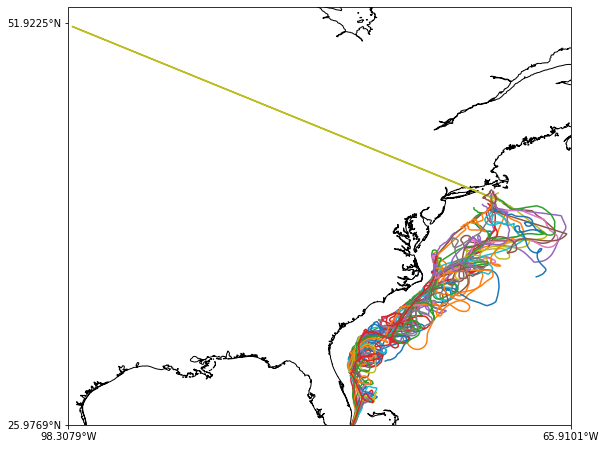

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map():
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.coastlines(resolution="10m")
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


fig, ax = make_map()
lons, lats = [], []
for glider, df in dfs.items():
    lon, lat = df["longitude"], df["latitude"]
    lons.extend(lon.array)
    lats.extend(lat.array)
    ax.plot(lon, lat)

dx = dy = 0.25
extent = min(lons)-dx, max(lons)+dx, min(lats)+dy, max(lats)+dy
ax.set_extent(extent)

ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree());

(5.5, 30.0, 30.0, 38.0)

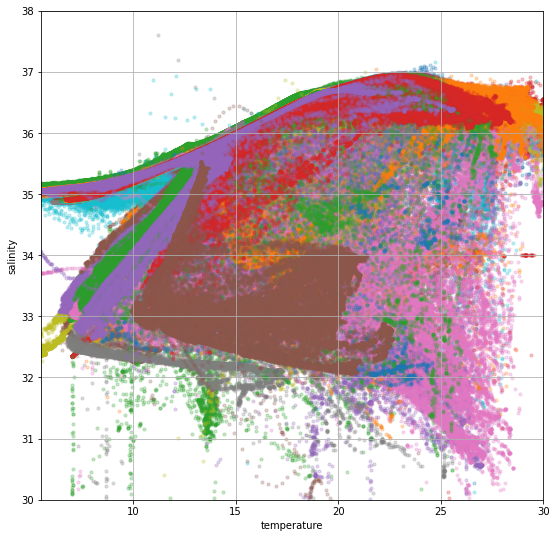

In [19]:
def glider_scatter(df, ax):
    ax.scatter(df["temperature"], df["salinity"],
               s=10, alpha=0.25)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel("salinity")
ax.set_xlabel("temperature")
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax)

ax.axis([5.5, 30, 30, 38]);

## Extra convenience methods for common responses

### OPeNDAP

In [20]:
from netCDF4 import Dataset


e.constraints = None
e.protocol = "tabledap"
e.dataset_id = "whoi_406-20160902T1700"

opendap_url = e.get_download_url(
    response="opendap",
)

print(opendap_url)
with Dataset(opendap_url) as nc:
    print(nc.summary)

https://gliders.ioos.us/erddap/tabledap/whoi_406-20160902T1700
Slocum glider dataset gathered as part of the TEMPESTS (The Experiment to Measure and Predict East coast STorm Strength), funded by NOAA through CINAR (Cooperative Institute for the North Atlantic Region).


### netCDF Climate and Forecast

In [21]:
e.response = "nc"
e.variables = ["longitude", "latitude", "temperature", "salinity"]

nc = e.to_ncCF()

print(nc.Conventions)
print(nc["temperature"])

Unidata Dataset Discovery v1.0, COARDS, CF-1.6
<class 'netCDF4._netCDF4.Variable'>
float32 temperature(obs)
    _ChunkSizes: 73
    _FillValue: -999.0
    actual_range: [ 9.9473 22.6177]
    ancillary_variables: qartod_temperature_climatological_flag qartod_temperature_flat_line_flag qartod_temperature_gross_range_flag qartod_temperature_rate_of_change_flag qartod_temperature_spike_flag temperature_qc
    colorBarMaximum: 32.0
    colorBarMinimum: 0.0
    coordinates: time latitude longitude depth
    instrument: instrument_ctd
    ioos_category: Temperature
    long_name: Sea Water Temperature
    observation_type: measured
    platform: platform
    standard_name: sea_water_temperature
    units: Celsius
    valid_max: 40.0
    valid_min: -5.0
unlimited dimensions: 
current shape = (54245,)
filling on


### xarray

In [22]:
ds = e.to_xarray(decode_times=False)

ds

<xarray.Dataset>
Dimensions:          (obs: 54245, profile: 525, trajectory: 1)
Coordinates:
  * trajectory       (trajectory) object 'whoi_406-20160902T1700'
    time             (profile) float64 ...
    longitude        (profile) float64 ...
    latitude         (profile) float64 ...
    depth            (obs) float32 ...
Dimensions without coordinates: obs, profile
Data variables:
    profile_id       (profile) float64 ...
    trajectoryIndex  (profile) int32 ...
    rowSize          (profile) int32 ...
    temperature      (obs) float32 ...
    salinity         (obs) float32 ...
Attributes:
    acknowledgment:                This deployment supported by NOAA through ...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operatored by Woods Hole Oceanograp...
    contributor_name:              Robert Todd, Larry George, Patrick Deane, ...
    contributor_role:              Principal Investigator, pilot and technici...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 rtodd@whoi.edu
    creator_name:                  Robert Todd
    creator_url:                   gliders.whoi.edu
    date_created:                  2016-09-20T10:06:04Z
    date_issued:                   2016-09-20T10:06:04Z
    Easternmost_Easting:           -70.67537291773046
    featureType:                   TrajectoryProfile
    format_version:                /tmp/IOOS_Glider_NetCDF_v2.0-qartod.nc
    geospatial_lat_max:            41.120018298037856
    geospatial_lat_min:            40.257794149155615
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            -70.67537291773046
    geospatial_lon_min:            -71.54982816987487
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       98.05
    geospatial_vertical_min:       2.49
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    gts_ingest:                    true
    history:                       2016-09-20T10:06:04Z /home/kerfoot/slocum/...
    id:                            whoi_406-20160920T1329
    infoUrl:                       https://gliders.ioos.us/erddap/
    institution:                   Woods Hole Oceanographic Institution
    ioos_dac_checksum:             6e67c5e2c364def562bb32242dec8fd5
    ioos_dac_completed:            True
    keywords:                      AUVS > Autonomous Underwater Vehicles, Ear...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       This data may be redistributed and used wi...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0, COARDS, CF...
    naming_authority:              edu.rutgers.marine
    Northernmost_Northing:         41.120018298037856
    platform_type:                 Slocum Glider
    project:                       TEMPESTS
    publisher_email:               kerfoot@marine.rutgers.edu
    publisher_name:                John Kerfoot
    publisher_url:                 https://rucool/marine.rutgers.edu
    references:                    https://ioos.noaa.gov/wp-content/uploads/2...
    sea_name:                      Mid-Atlantic Bight
    source:                        Observational data from a profiling glider
    sourceUrl:                     (local files)
    Southernmost_Northing:         40.257794149155615
    standard_name_vocabulary:      CF-v25
    subsetVariables:               trajectory,wmo_id,time_uv,lat_uv,lon_uv,u,...
    summary:                       Slocum glider dataset gathered as part of ...
    time_coverage_end:             2016-09-20T13:32:33Z
    time_coverage_start:           2016-09-02T17:05:38Z
    title:                         whoi_406-20160902T1700
    Westernmost_Easting:           -71.54982816987487

Tabledap represents all data in tabular form and the next steps, while a bit awkward, are necessary to match the dimensions properly. The griddap response (unsupported at the moment) does not have this limitation.

In [23]:
row_size = ds["rowSize"].values
lon = ds["longitude"].values
lat = ds["latitude"].values

lons, lats = [], []
for x, y, r in zip(lon, lat, row_size):
    lons.extend([x]*r)
    lats.extend([y]*r)

In [24]:
import numpy as np


data = ds["temperature"].values
depth = ds["depth"].values

mask = ~np.ma.masked_invalid(depth).mask

data = data[mask]
depth = depth[mask]
lons = np.array(lons)[mask]
lats = np.array(lats)[mask]

In [25]:
mask = depth <= 5

data = data[mask]
depth = depth[mask]
lons = lons[mask]
lats = lats[mask]

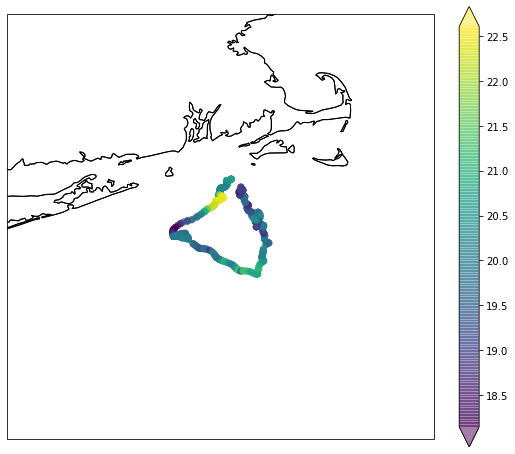

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


dx = dy = 1.5
extent = (
    ds.geospatial_lon_min-dx, ds.geospatial_lon_max+dx,
    ds.geospatial_lat_min-dy, ds.geospatial_lat_max+dy
)
fig, ax = make_map()

cs = ax.scatter(lons, lats, c=data, s=50, alpha=0.5, edgecolor="none")
cbar = fig.colorbar(cs, orientation="vertical",
                    fraction=0.1, shrink=0.9, extend="both")
ax.set_extent(extent)
ax.coastlines("10m");

### iris

In [27]:
import warnings

# Iris warnings are quire verbose!
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = e.to_iris()

print(cubes)

0: sea_water_practical_salinity / (1)  (-- : 54245)
1: Trajectory Name / (1)               (-- : 1)
2: sea_water_temperature / (Celsius)   (-- : 54245)
3: Profile ID / (1)                    (-- : 525)
4: Number of Observations for this Profile / (1) (-- : 525)
5: The trajectory to which this profile is associated. / (1) (-- : 525)
6: time / (seconds since 1970-01-01T00:00:00Z) (-- : 525)
7: longitude / (degrees)               (-- : 525)
8: latitude / (degrees)                (-- : 525)


In [28]:
cubes.extract_strict("sea_water_temperature")

Sea Water Temperature (Celsius),--
Shape,54245
Auxiliary coordinates,
depth,x
Attributes,
Conventions,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
Easternmost_Easting,-70.67537291773046
Metadata_Conventions,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
Northernmost_Northing,41.120018298037856
Southernmost_Northing,40.257794149155615
Westernmost_Easting,-71.54982816987487


This example is written in a Jupyter Notebook
[click here](https://raw.githubusercontent.com/ioos/erddapy/master/notebooks/quick_intro.ipynb)
to download the notebook so you can run it locally, or [click here](https://binder.pangeo.io/v2/gh/ioos/erddapy/master?filepath=notebooks/quick_intro.ipynb) to run a live instance of this notebook.